# 1. Imports & Utilities

In [ ]:
import pandas as pd
import numpy as np
import os

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input, Bidirectional, Lambda, merge, TimeDistributed, Embedding, Permute, RepeatVector, Activation, Flatten, GRU, Dropout, GaussianNoise, Maximum, Multiply
from keras import backend as K

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import resample

from google.colab import drive
drive.mount('/content/drive')
base_path = "/content/drive/MyDrive/HLT Project/"

Mounted at /content/drive


In [ ]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 4.3 MB/s 
     |████████████████████████████████| 596 kB 29.2 MB/s 
     |████████████████████████████████| 6.6 MB 33.5 MB/s 
     |████████████████████████████████| 86 kB 4.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
#function to plot accuracy and loss during training
def plot(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [ ]:
tf.keras.utils.set_random_seed(7)

#2. Getting the Data

In [ ]:
#! gdown --id 13O7T4KGfd6yuJYP0cvbZtMJj_8nYaCVX
#dataset = pd.read_pickle('preprocessed_lemmas.pk1')
#! rm preprocessed_lemmas.pk1
! gdown --id 1-4pmYeb9RNgsL4g6o1jKBUDLCPWd37i5
! gdown --id 1-9qpVXoR68jpR3QuZzyIS4MVSWdI5wYz
! gdown --id 19GFJQYAoeQmjQ6a1lms1Traldl_OY_u2
! gdown --id 1-9aXJolDN3z05gP8i23CKofeytH4DDa3
tune = pd.read_pickle('tune.pk1')
train = pd.read_pickle('train.pk1')
valid = pd.read_pickle('valid.pk1')
test = pd.read_pickle('test.pk1')
! rm tune.pk1
! rm train.pk1
! rm valid.pk1
! rm test.pk1
print(str(len(tune))+", " +str(len(train))+", "+ str(len(valid))+", " +str(len(test)))
tune_len = len(tune)
train_len = len(train)
valid_len = len(valid)
dataset = tune.append(train).append(valid).append(test)
dataset = dataset.reset_index(drop=True)
len(dataset)

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-4pmYeb9RNgsL4g6o1jKBUDLCPWd37i5
To: /content/test.pk1
100% 12.3k/12.3k [00:00<00:00, 6.12MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-9qpVXoR68jpR3QuZzyIS4MVSWdI5wYz
To: /content/train.pk1
100% 87.3k/87.3k [00:00<00:00, 44.4MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://

671

In [ ]:
tweets = dataset['tweet']
words = set()
max = 0
for tweet in tweets:
  if max < len(tweet):
    max = len(tweet)
  for word in tweet:
    words.add(word)
sentiments = dataset.scale.unique()
max, len(words), len(sentiments)

(41, 3046, 3)

###Checking balance of data

In [ ]:
dataset['scale'].value_counts()

0     310
1     307
-1     54
Name: scale, dtype: int64

# Train-Test Split

In [ ]:
#try splitting tweets based on scale
target_column = 'scale'
class_col = 'scale'

dataset[target_column] = dataset[target_column].astype('category')
dataset[class_col] = dataset[class_col].astype('category')

#train_split = 0.8
#valtest_split = 0.5
#tune_split = 0.03
#run only once
#dev, tune = train_test_split(dataset, test_size=tune_split, random_state=42, shuffle=True, stratify=dataset[target_column])
#train, valtest = train_test_split(dev, test_size=(1.0-train_split), shuffle=True, stratify=dev[target_column])
#valid, test = train_test_split(valtest, test_size=(1.0-valtest_split), shuffle=True, stratify=valtest[target_column])

#for balancing
#n_samples=train['tweet'][train['scale'] == 0].shape[0]-train['tweet'][train['scale'] == -1].shape[0]

#train_oversampled, sentiment_oversampled = resample(train['tweet'][train['scale'] == -1],
#                                        train['scale'][train['scale'] == -1],
#                                        replace=True,
#                                        n_samples=n_samples,
#                                        random_state=123)
#train_oversampled, sentiment_oversampled
#extra = pd.DataFrame({'tweet': train_oversampled, 'scale':sentiment_oversampled})
#extra= extra.reset_index(drop=True)
#train = train.append(extra)
#train = train.reset_index(drop=True)
#len(train), train, train['scale'].value_counts()
#output_file_path = os.path.join(base_path, "Data/tune.pk1")
#tune.to_pickle(output_file_path)
#output_file_path = os.path.join(base_path, "Data/train.pk1")
#train.to_pickle(output_file_path)
#output_file_path = os.path.join(base_path, "Data/valid.pk1")
#valid.to_pickle(output_file_path)
#output_file_path = os.path.join(base_path, "Data/test.pk1")
#test.to_pickle(output_file_path)


tune = dataset[:tune_len]
train = dataset[tune_len:tune_len+train_len]
valid = dataset[tune_len+train_len:tune_len+train_len+valid_len]
test = dataset[tune_len+train_len+valid_len:]
len(tune), len(train), len(test), len(valid)

(21, 520, 65, 65)

In [ ]:
#try splitting tweets based on scale
"""
target_column = 'scale'
class_col = 'scale'

dataset[target_column] = dataset[target_column].astype('category')
dataset[class_col] = dataset[class_col].astype('category')

from sklearn.model_selection import train_test_split

# 80/10/10 train/val/test split
train, valtest = train_test_split(dataset, test_size=0.2, random_state=42, shuffle=True, stratify=dataset[target_column])
valid, test = train_test_split(valtest, test_size=0.5, shuffle=True, stratify=valtest[target_column])
train, valid, test
"""

"\ntarget_column = 'scale'\nclass_col = 'scale'\n\ndataset[target_column] = dataset[target_column].astype('category')\ndataset[class_col] = dataset[class_col].astype('category')\n\nfrom sklearn.model_selection import train_test_split\n\n# 80/10/10 train/val/test split\ntrain, valtest = train_test_split(dataset, test_size=0.2, random_state=42, shuffle=True, stratify=dataset[target_column])\nvalid, test = train_test_split(valtest, test_size=0.5, shuffle=True, stratify=valtest[target_column])\ntrain, valid, test\n"

#3. Prepare the Data for the Neural Network

In [ ]:
word2index = {w: i+1 for i, w in enumerate(words)}
tune_tweets = [ [word2index.get(w) for w in s] for s in tune['tweet']]
train_tweets = [ [word2index.get(w) for w in s] for s in train['tweet']]
valid_tweets = [ [word2index.get(w) for w in s] for s in valid['tweet']]
test_tweets = [ [word2index.get(w) for w in s] for s in test['tweet']]

tune_tweets = pad_sequences(tune_tweets, padding='post', maxlen=max)
train_tweets = pad_sequences(train_tweets, padding='post', maxlen=max)
valid_tweets = pad_sequences(valid_tweets, padding='post', maxlen=max)
test_tweets = pad_sequences(test_tweets, padding='post', maxlen=max)

tune_sentiments = [sentiment for sentiment in tune['scale']]
tune_sentiments = to_categorical(np.array(tune_sentiments), len(sentiments))
train_sentiments = [sentiment for sentiment in train['scale']]
train_sentiments = to_categorical(np.array(train_sentiments), len(sentiments))
valid_sentiments = [sentiment for sentiment in valid['scale']]
valid_sentiments = to_categorical(np.array(valid_sentiments), len(sentiments))
test_sentiments = [sentiment for sentiment in test['scale']]
test_sentiments = to_categorical(np.array(test_sentiments), len(sentiments))

#4.1 Simple Model

###Model Definition

In [ ]:
from sklearn.model_selection import GridSearchCV

np.random.seed(42)
input_dim = tune_tweets.shape[1]

def define_model(activation='relu', init_weights='uniform', lr=5e-05, embedding_dim=64, rnn_hidden_size=128, l2=0.001,
                 batch_size=32, dropout=0.3, noise=0.3, clipnorm=1, dense=16, return_seq=True):
  model = Sequential()
  model.add(Embedding(input_dim=len(word2index)+1, output_dim=embedding_dim, input_length=max, mask_zero=True))
  model.add(GaussianNoise(noise))
  model.add(Bidirectional(LSTM(rnn_hidden_size, kernel_initializer=init_weights, return_sequences=return_seq, dropout=dropout)))
  model.add(Dropout(dropout))
  if return_seq:
    model.add(Flatten())
  model.add(Dense(dense, activation=activation, kernel_initializer=init_weights))
  model.add(Dropout(dropout))
  model.add(Dense(len(sentiments), kernel_initializer=init_weights, activation='softmax', activity_regularizer=regularizers.l2(l2)))

  opt = tf.keras.optimizers.Adam(
      clipnorm=clipnorm,
      learning_rate=lr,
      name='Adam')

  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  return model


  

##Hyperparamter Tuning

###Tuning the Optimizer

In [ ]:
from scikeras.wrappers import KerasClassifier
model = KerasClassifier(model=define_model,
                        activation='relu',
                        init_weights='uniform',
                        lr=5e-05,
                        embedding_dim=64,
                        rnn_hidden_size=128,
                        l2=0.001,
                        batch_size=32,
                        dropout=0.3,
                        noise=0.3,
                        clipnorm=1,
                        dense=16,
                        return_seq=True,
                        epochs=20,
                        verbose=1)
activation=['relu','sigmoid', 'tanh', 'elu']
init_weights=['random_uniform', 'uniform', 'orthogonal']
lr=[5e-05,5e-03,5e-01]
embedding_dim=[16,32,64,128]
rnn_hidden_size=[32,64,128,256]
l2=[0.1,0.01,0.001,0.0001]
batch_size=[8,16,32]
dropout=[0.3,0.5,0.8]
noise=[0.3,0.5,0.8]
clipnorm=[1,3,5]
dense=[8,16,32]
return_seq=[True,False]

param_grid=dict(init_weights=init_weights,
                batch_size=batch_size,
                lr=lr,
                clipnorm=clipnorm)

grid = GridSearchCV(estimator=model,param_grid=param_grid,cv=3)
grid_result=grid.fit(tune_tweets,tune_sentiments)

print(grid_result.best_score_)
print(grid_result.best_params_)

"""
0.6190476190476191
best params = {'batch_size': 16, 'clipnorm': 3, 'init_weights': 'uniform', 'lr': 5e-05}
"""

###Tuning the Regularization/Dropout

In [ ]:
from scikeras.wrappers import KerasClassifier
model = KerasClassifier(model=define_model,
                        activation='relu',
                        init_weights='uniform',
                        lr=5e-05,
                        embedding_dim=64,
                        rnn_hidden_size=128,
                        l2=0.001,
                        batch_size=16,
                        dropout=0.3,
                        noise=0.3,
                        clipnorm=3,
                        dense=16,
                        return_seq=True,
                        epochs=20,
                        verbose=1)

activation=['relu','sigmoid', 'tanh', 'elu']
#embedding_dim=[16,32,64,128]
#rnn_hidden_size=[32,64,128,256]
l2=[0.1,0.01,0.001,0.0001]
dropout=[0.3,0.5,0.8]
noise=[0.3,0.5,0.8]
#dense=[8,16,32]
#return_seq=[True,False]

param_grid=dict(activation=activation,
                l2=l2,
                dropout=dropout,
                noise=noise)

grid = GridSearchCV(estimator=model,param_grid=param_grid,cv=3)
grid_result=grid.fit(tune_tweets,tune_sentiments)

print(grid_result.best_score_)
print(grid_result.best_params_)

"""
0.6666666666666666
{'activation': 'sigmoid', 'dropout': 0.5, 'l2': 0.1, 'noise': 0.5}
"""

###Tuning the Hidden Neurons

In [ ]:
from scikeras.wrappers import KerasClassifier
model = KerasClassifier(model=define_model,
                        activation='sigmoid',
                        init_weights='uniform',
                        lr=5e-05,
                        embedding_dim=64,
                        rnn_hidden_size=128,
                        l2=0.1,
                        batch_size=16,
                        dropout=0.5,
                        noise=0.5,
                        clipnorm=3,
                        dense=16,
                        return_seq=True,
                        epochs=20,
                        verbose=1)

embedding_dim=[16,32,64,128]
rnn_hidden_size=[32,64,128,256]
dense=[8,16,32]
return_seq=[True,False]

param_grid=dict(embedding_dim=embedding_dim,
                rnn_hidden_size=rnn_hidden_size,
                dense=dense,
                return_seq=return_seq)

grid = GridSearchCV(estimator=model,param_grid=param_grid,cv=3)
grid_result=grid.fit(tune_tweets,tune_sentiments)

print(grid_result.best_score_)
print(grid_result.best_params_)
"""
0.6666666666666666
{'dense': 8, 'embedding_dim': 16, 'return_seq': True, 'rnn_hidden_size': 32}
"""

##Training the Model

In [ ]:
#set hyperparameters to best ones obtained via grid search
EPOCHS = 1000
ACTIVATION='sigmoid'
INIT_WEIGHTS='uniform'
LR = 5e-05
EMBEDDING_DIM = 16
RNN_HIDDEN_SIZE = 32
L2=0.1
BATCH_SIZE = 16
DROPOUT=0.5
NOISE=0.5
CLIPNORM=3
DENSE=8
RETURN_SEQUENCE=True


model = define_model(activation=ACTIVATION,
                     init_weights=INIT_WEIGHTS,
                     lr=LR,
                     embedding_dim=EMBEDDING_DIM,
                     rnn_hidden_size=RNN_HIDDEN_SIZE,
                     l2=L2,
                     batch_size=BATCH_SIZE,
                     dropout=DROPOUT,
                     noise=NOISE,
                     clipnorm=CLIPNORM,
                     dense=DENSE,
                     return_seq=RETURN_SEQUENCE)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 41, 16)            48752     
                                                                 
 gaussian_noise (GaussianNoi  (None, 41, 16)           0         
 se)                                                             
                                                                 
 bidirectional (Bidirectiona  (None, 41, 64)           12544     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 41, 64)            0         
                                                                 
 flatten (Flatten)           (None, 2624)              0         
                                                                 
 dense (Dense)               (None, 8)                 2

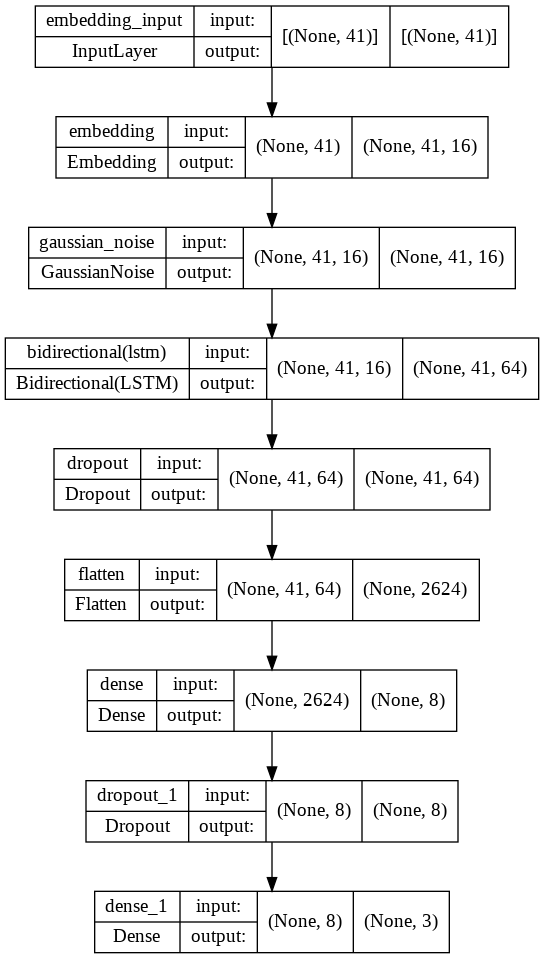

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath='ckpt_1',
  save_weights_only=True,
  monitor='val_accuracy',
  mode='max',
  save_best_only=True
)

#early stop mechanism
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10
)

history = model.fit(train_tweets,
                    train_sentiments,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    shuffle=True,
                    validation_data=(valid_tweets,valid_sentiments),
                    callbacks=[checkpoint_callback, earlystop_callback])

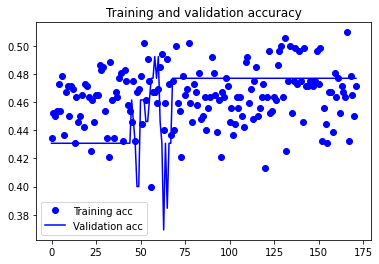

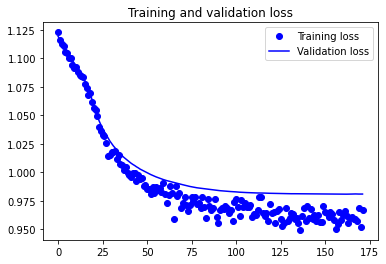

In [ ]:
plot(history)

###Save the Model

In [ ]:
model.load_weights('ckpt_1')

In [ ]:
train_loss, train_accuracy = model.evaluate(train_tweets, train_sentiments)
train_accuracy

17/17 [==============================] - 0s 5ms/step - loss: 0.9733 - accuracy: 0.4769


0.4769230782985687

In [ ]:
valid_loss, valid_accuracy = model.evaluate(valid_tweets, valid_sentiments)
valid_accuracy

3/3 [==============================] - 0s 6ms/step - loss: 0.9942 - accuracy: 0.4923


0.4923076927661896

In [ ]:
test_loss, test_accuracy = model.evaluate(test_tweets, test_sentiments)
test_accuracy

3/3 [==============================] - 0s 8ms/step - loss: 1.0111 - accuracy: 0.4769


0.4769230782985687

In [ ]:
output_file_path = os.path.join(base_path, "Models/simple")
model.save(output_file_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/HLT Project/Models/simple/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/HLT Project/Models/simple/assets


#4.2 Initial Deep Model 

##Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

np.random.seed(42)
input_dim = tune_tweets.shape[1]

def define_lstm_deep_model(activation='relu', init_weights='uniform', lr=5e-05, embedding_dim=64, rnn_hidden_size=128, l2=0.001,
                           batch_size=32, dropout=0.3, noise=0.3, clipnorm=1, dense=16, return_seq=True):
  model = Sequential()
  model.add(Embedding(input_dim=len(word2index)+1, output_dim=embedding_dim, input_length=max, mask_zero=True))
  model.add(GaussianNoise(noise))
  model.add(Bidirectional(LSTM(rnn_hidden_size, kernel_initializer=init_weights, return_sequences=return_seq, dropout=dropout, recurrent_dropout=dropout)))
  model.add(Dropout(dropout))
  model.add(Bidirectional(LSTM(int(rnn_hidden_size*2), kernel_initializer=init_weights, return_sequences=return_seq, dropout=dropout, recurrent_dropout=dropout)))
  model.add(Dropout(dropout))
  if return_seq:
    model.add(Flatten())
  model.add(Dense(int(dense*64), kernel_initializer=init_weights, activation=activation))
  model.add(Dropout(dropout))
  model.add(Dense(int(dense*8), kernel_initializer=init_weights, activation=activation))
  model.add(Dropout(dropout))
  model.add(Dense(dense, kernel_initializer=init_weights, activation=activation))
  model.add(Dropout(dropout))
  model.add(Dense(len(sentiments), kernel_initializer=init_weights, activation='softmax', activity_regularizer=regularizers.l2(l2)))

  opt = tf.keras.optimizers.Adam(
      clipnorm=clipnorm,
      learning_rate=lr,
      name='Adam')

  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  return model


  

###Tuning the Optimizer

In [ ]:

from scikeras.wrappers import KerasClassifier
model = KerasClassifier(model=define_lstm_deep_model,
                        activation='sigmoid',
                        init_weights='uniform',
                        lr=5e-05,
                        embedding_dim=16,
                        rnn_hidden_size=32,
                        l2=0.1,
                        batch_size=16,
                        dropout=0.5,
                        noise=0.5,
                        clipnorm=3,
                        dense=8,
                        return_seq=True,
                        epochs=20,
                        verbose=1)
init_weights=['random_uniform', 'uniform', 'orthogonal']
lr=[5e-05,5e-03,5e-01]
batch_size=[8,16,32]
clipnorm=[1,3,5]

param_grid=dict(init_weights=init_weights,
                batch_size=batch_size,
                lr=lr,
                clipnorm=clipnorm)

grid = GridSearchCV(estimator=model,param_grid=param_grid,cv=3)
grid_result=grid.fit(tune_tweets,tune_sentiments)

print(grid_result.best_score_)
print(grid_result.best_params_)
"""
best_score: 0.6666666666666666
best_params: {'batch_size': 8, 'clipnorm': 1, 'init_weights': 'orthogonal', 'lr': 5e-05}
"""

###Tuning the Regularization/Dropout

In [ ]:
from scikeras.wrappers import KerasClassifier
model = KerasClassifier(model=define_lstm_deep_model,
                        activation='sigmoid',
                        init_weights='orthogonal',
                        lr=5e-05,
                        embedding_dim=16,
                        rnn_hidden_size=32,
                        l2=0.1,
                        batch_size=8,
                        dropout=0.5,
                        noise=0.5,
                        clipnorm=1,
                        dense=8,
                        return_seq=True,
                        epochs=20,
                        verbose=1)
activation=['relu','sigmoid', 'elu']
l2=[0.01,0.001,0.0001]
dropout=[0.3,0.5,0.8]
noise=[0.3,0.5,0.8]

param_grid=dict(activation=activation,
                l2=l2,
                dropout=dropout,
                noise=noise)

grid = GridSearchCV(estimator=model,param_grid=param_grid,cv=3)
grid_result=grid.fit(tune_tweets,tune_sentiments)

print(grid_result.best_score_)
print(grid_result.best_params_)
"""
0.6666666666666666
{'activation': 'sigmoid', 'dropout': 0.3, 'l2': 0.0001, 'noise': 0.8}
"""

###Tuning the Hidden Neurons

In [ ]:
from scikeras.wrappers import KerasClassifier
model = KerasClassifier(model=define_lstm_deep_model,
                        activation='sigmoid',
                        init_weights='orthogonal',
                        lr=5e-05,
                        embedding_dim=64,
                        rnn_hidden_size=128,
                        l2=0.0001,
                        batch_size=8,
                        dropout=0.3,
                        noise=0.8,
                        clipnorm=1,
                        dense=16,
                        return_seq=True,
                        epochs=20,
                        verbose=1)
embedding_dim=[16,32,64]
rnn_hidden_size=[32,64,128]
dense=[8,16,32]
return_seq=[True,False]

param_grid=dict(embedding_dim=embedding_dim,
                rnn_hidden_size=rnn_hidden_size,
                dense=dense,
                return_seq=return_seq)

grid = GridSearchCV(estimator=model,param_grid=param_grid,cv=3)
grid_result=grid.fit(tune_tweets,tune_sentiments)

print(grid_result.best_score_)
print(grid_result.best_params_)
"""
0.5714285714285715
{'dense': 8, 'embedding_dim': 64, 'return_seq': True, 'rnn_hidden_size': 32}
"""

##Training the model

In [ ]:
#set hyperparameters to best ones obtained via grid search
EPOCHS = 1000
ACTIVATION='sigmoid'
INIT_WEIGHTS='orthogonal'
LR = 5e-05
EMBEDDING_DIM = 64
RNN_HIDDEN_SIZE = 32
L2=0.0001
BATCH_SIZE = 8
DROPOUT=0.3
NOISE=0.8
CLIPNORM=1
DENSE=8
RETURN_SEQUENCE=True


model = define_lstm_deep_model(activation=ACTIVATION,
                               init_weights=INIT_WEIGHTS,
                               lr=LR,
                               embedding_dim=EMBEDDING_DIM,
                               rnn_hidden_size=RNN_HIDDEN_SIZE,
                               l2=L2,
                               batch_size=BATCH_SIZE,
                               dropout=DROPOUT,
                               noise=NOISE,
                               clipnorm=CLIPNORM,
                               dense=DENSE,
                               return_seq=RETURN_SEQUENCE)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 41, 64)            195008    
                                                                 
 gaussian_noise (GaussianNoi  (None, 41, 64)           0         
 se)                                                             
                                                                 
 bidirectional (Bidirectiona  (None, 41, 64)           24832     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 41, 64)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 41, 128)          66048     
 nal)                                                            
                                                        

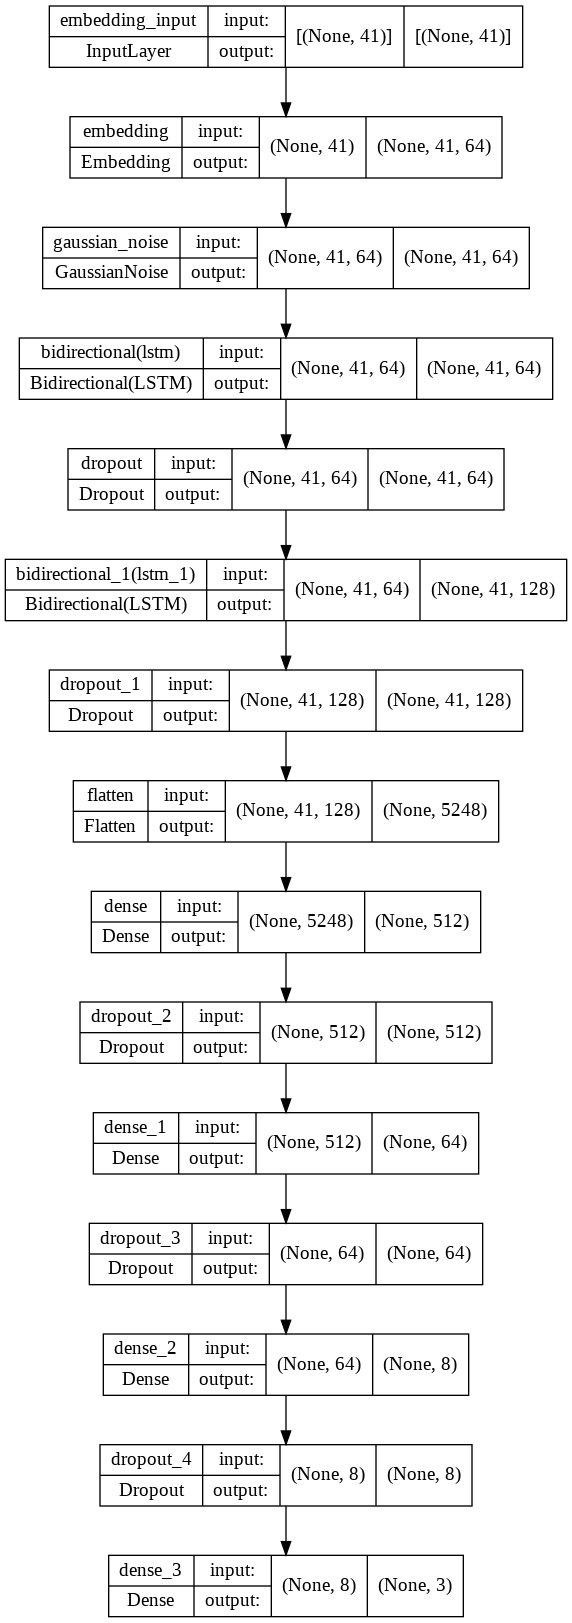

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath='ckpt_1',
  save_weights_only=True,
  monitor='val_accuracy',
  mode='max',
  save_best_only=True
)

#early stop mechanism
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10
)

history = model.fit(train_tweets,
                    train_sentiments,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    shuffle=True,
                    validation_data=(valid_tweets,valid_sentiments),
                    callbacks=[checkpoint_callback, earlystop_callback])

Epoch 1/1000
65/65 [==============================] - 24s 187ms/step - loss: 1.1779 - accuracy: 0.4019 - val_loss: 1.1076 - val_accuracy: 0.4308
Epoch 2/1000
65/65 [==============================] - 10s 156ms/step - loss: 1.1140 - accuracy: 0.4365 - val_loss: 1.0634 - val_accuracy: 0.4308
Epoch 3/1000
65/65 [==============================] - 13s 196ms/step - loss: 1.0678 - accuracy: 0.4423 - val_loss: 1.0350 - val_accuracy: 0.4308
Epoch 4/1000
65/65 [==============================] - 10s 157ms/step - loss: 1.0348 - accuracy: 0.4558 - val_loss: 1.0174 - val_accuracy: 0.4308
Epoch 5/1000
65/65 [==============================] - 10s 157ms/step - loss: 1.0193 - accuracy: 0.4596 - val_loss: 1.0043 - val_accuracy: 0.4308
Epoch 6/1000
65/65 [==============================] - 10s 157ms/step - loss: 1.0005 - accuracy: 0.4481 - val_loss: 0.9944 - val_accuracy: 0.4308
Epoch 7/1000
65/65 [==============================] - 11s 176ms/step - loss: 1.0078 - accuracy: 0.4577 - val_loss: 0.9872 - val_ac

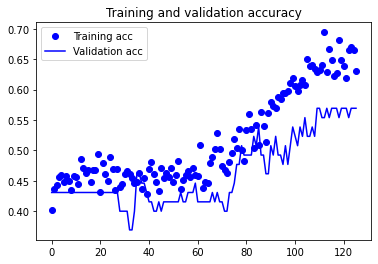

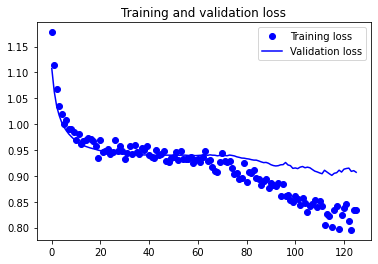

In [ ]:
plot(history)

In [ ]:
model.load_weights('ckpt_1')

In [ ]:
train_loss, train_accuracy = model.evaluate(train_tweets, train_sentiments)
train_accuracy

17/17 [==============================] - 1s 36ms/step - loss: 0.6772 - accuracy: 0.8404


0.8403846025466919

In [ ]:
valid_loss, valid_accuracy = model.evaluate(valid_tweets, valid_sentiments)
valid_accuracy

3/3 [==============================] - 0s 33ms/step - loss: 0.9077 - accuracy: 0.5692


0.5692307949066162

In [ ]:
test_loss, test_accuracy = model.evaluate(test_tweets, test_sentiments)
test_accuracy

3/3 [==============================] - 0s 29ms/step - loss: 0.9015 - accuracy: 0.5846


0.5846154093742371

In [ ]:
output_file_path = os.path.join(base_path, "Models/bi_2_LSTM")
model.save(output_file_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/HLT Project/Models/bi_2_LSTM/assets


#4.3 LSTM + CNN

##Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

np.random.seed(42)
input_dim = tune_tweets.shape[1]

def define_lstm_cnn_model(activation='relu', init_weights='uniform', lr=5e-05, embedding_dim=64, rnn_hidden_size=128, l2=0.001,
                          batch_size=32, dropout=0.3, noise=0.3, clipnorm=1, dense=16, return_seq=True,
                          n_filters=512, kernel_size=10, pool_size=4):
  model = Sequential()
  model.add(Embedding(input_dim=len(word2index)+1, output_dim=embedding_dim, input_length=max, mask_zero=True))
  model.add(GaussianNoise(noise))
  model.add(Bidirectional(LSTM(rnn_hidden_size, kernel_initializer=init_weights, return_sequences=return_seq, dropout=dropout, recurrent_dropout=dropout)))
  model.add(Dropout(dropout))
  model.add(Bidirectional(LSTM(int(rnn_hidden_size*2), kernel_initializer=init_weights, return_sequences=return_seq, dropout=dropout, recurrent_dropout=dropout)))
  model.add(Dropout(dropout))
  model.add(tf.keras.layers.Conv1D(n_filters, kernel_size, kernel_initializer=init_weights, activation=activation))
  model.add(tf.keras.layers.MaxPooling1D(pool_size=pool_size))
  model.add(Dropout(dropout))
  model.add(Dense(dense, kernel_initializer=init_weights, activation=activation))
  model.add(Dropout(dropout))
  model.add(Flatten())
  model.add(Dense(len(sentiments), kernel_initializer=init_weights, activation='softmax', activity_regularizer=regularizers.l2(l2)))

  opt = tf.keras.optimizers.Adam(
      clipnorm=clipnorm,
      learning_rate=lr,
      name='Adam')

  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  return model


  

###Tuning the Optimizer

In [ ]:
from scikeras.wrappers import KerasClassifier
model = KerasClassifier(model=define_lstm_cnn_model,
                        activation='relu',
                        init_weights='uniform',
                        lr=5e-05,
                        embedding_dim=64,
                        rnn_hidden_size=32,
                        l2=0.001,
                        batch_size=8,
                        dropout=0.3,
                        noise=0.3,
                        clipnorm=1,
                        dense=8,
                        return_seq=True,
                        epochs=20,
                        n_filters=32,
                        kernel_size=10,
                        pool_size=4,
                        verbose=1)
init_weights=['random_uniform', 'uniform', 'orthogonal']
lr=[5e-05,5e-03,5e-01]
batch_size=[8,16,32]
clipnorm=[1,3,5]

param_grid=dict(init_weights=init_weights,
                batch_size=batch_size,
                lr=lr,
                clipnorm=clipnorm)

grid = GridSearchCV(estimator=model,param_grid=param_grid,cv=3)
grid_result=grid.fit(tune_tweets,tune_sentiments)

print(grid_result.best_score_)
print(grid_result.best_params_)
"""
0.6190476190476191
{'batch_size': 16, 'clipnorm': 1, 'init_weights': 'orthogonal', 'lr': 5e-05}
"""


Streaming output truncated to the last 5000 lines.
Epoch 13/20
1/1 [==============================] - 1s 907ms/step - loss: 1.0987 - accuracy: 0.5000
Epoch 14/20
1/1 [==============================] - 1s 799ms/step - loss: 1.0987 - accuracy: 0.6429
Epoch 15/20
1/1 [==============================] - 1s 803ms/step - loss: 1.0987 - accuracy: 0.4286
Epoch 16/20
1/1 [==============================] - 1s 826ms/step - loss: 1.0987 - accuracy: 0.5000
Epoch 17/20
1/1 [==============================] - 1s 878ms/step - loss: 1.0986 - accuracy: 0.6429
Epoch 18/20
1/1 [==============================] - 1s 915ms/step - loss: 1.0986 - accuracy: 0.6429
Epoch 19/20
1/1 [==============================] - 1s 812ms/step - loss: 1.0986 - accuracy: 0.2857
Epoch 20/20
1/1 [==============================] - 1s 1s/step
Epoch 1/20
1/1 [==============================] - 14s 14s/step - loss: 1.0990 - accuracy: 0.3571
Epoch 2/20
1/1 [==============================] - 1s 944ms/step - loss: 1.0967 - accuracy: 0.5000

"\n0.5714285714285715\n{'batch_size': 8, 'clipnorm': 1, 'init_weights': 'random_uniform', 'lr': 5e-05}\n"

###Tuning the Regularization/Droput

In [ ]:
from scikeras.wrappers import KerasClassifier
model = KerasClassifier(model=define_lstm_cnn_model,
                        activation='relu',
                        init_weights='orthogonal',
                        lr=5e-05,
                        embedding_dim=64,
                        rnn_hidden_size=32,
                        l2=0.001,
                        batch_size=16,
                        dropout=0.3,
                        noise=0.3,
                        clipnorm=1,
                        dense=8,
                        return_seq=True,
                        epochs=20,
                        n_filters=32,
                        kernel_size=10,
                        pool_size=4,
                        verbose=1)
activation=['relu','sigmoid', 'elu']
l2=[0.01,0.001,0.0001]
dropout=[0.3,0.5,0.8]
noise=[0.3,0.5,0.8]

param_grid=dict(activation=activation,
                l2=l2,
                dropout=dropout,
                noise=noise)

grid = GridSearchCV(estimator=model,param_grid=param_grid,cv=3)
grid_result=grid.fit(tune_tweets,tune_sentiments)

print(grid_result.best_score_)
print(grid_result.best_params_)
"""
0.5714285714285715
{'activation': 'relu', 'dropout': 0.3, 'l2': 0.01, 'noise': 0.8}
"""

Streaming output truncated to the last 5000 lines.
Epoch 13/20
1/1 [==============================] - 1s 781ms/step - loss: 2.0377 - accuracy: 0.2857
Epoch 14/20
1/1 [==============================] - 1s 865ms/step - loss: 1.5758 - accuracy: 0.4286
Epoch 15/20
1/1 [==============================] - 1s 730ms/step - loss: 1.2584 - accuracy: 0.5714
Epoch 16/20
1/1 [==============================] - 1s 757ms/step - loss: 1.9422 - accuracy: 0.2143
Epoch 17/20
1/1 [==============================] - 1s 856ms/step - loss: 1.9666 - accuracy: 0.0714
Epoch 18/20
1/1 [==============================] - 1s 780ms/step - loss: 1.6181 - accuracy: 0.3571
Epoch 19/20
1/1 [==============================] - 1s 919ms/step - loss: 1.5991 - accuracy: 0.1429
Epoch 20/20
1/1 [==============================] - 1s 957ms/step
Epoch 1/20
1/1 [==============================] - 11s 11s/step - loss: 1.4066 - accuracy: 0.2857
Epoch 2/20
1/1 [==============================] - 1s 745ms/step - loss: 2.4330 - accuracy: 0.2

###Tuning the Hidden Neurons

In [ ]:
from scikeras.wrappers import KerasClassifier
model = KerasClassifier(model=define_lstm_cnn_model,
                        activation='relu',
                        init_weights='orthogonal',
                        lr=5e-05,
                        embedding_dim=64,
                        rnn_hidden_size=32,
                        l2=0.01,
                        batch_size=16,
                        dropout=0.3,
                        noise=0.8,
                        clipnorm=1,
                        dense=8,
                        return_seq=True,
                        epochs=20,
                        n_filters=32,
                        kernel_size=10,
                        pool_size=4,
                        verbose=1)

embedding_dim=[16,32,64]
rnn_hidden_size=[32,64,128]
dense=[8,16,32]
return_seq=[True,False]


param_grid=dict(embedding_dim=embedding_dim,
                rnn_hidden_size=rnn_hidden_size,
                dense=dense,
                return_seq=return_seq)

grid = GridSearchCV(estimator=model,param_grid=param_grid,cv=3)
grid_result=grid.fit(tune_tweets,tune_sentiments)

print(grid_result.best_score_)
print(grid_result.best_params_)
"""
.5714285714285715
{'dense': 8, 'embedding_dim': 16, 'return_seq': True, 'rnn_hidden_size': 128}
"""

In [ ]:
from scikeras.wrappers import KerasClassifier
model = KerasClassifier(model=define_lstm_cnn_model,
                        activation='relu',
                        init_weights='orthogonal',
                        lr=5e-05,
                        embedding_dim=16,
                        rnn_hidden_size=128,
                        l2=0.01,
                        batch_size=16,
                        dropout=0.3,
                        noise=0.8,
                        clipnorm=1,
                        dense=8,
                        return_seq=True,
                        epochs=20,
                        n_filters=32,
                        kernel_size=10,
                        pool_size=4,
                        verbose=1)


n_filters=[32,64,256]
kernel_size=[3,5,7]
pool_size=[3,5,7]

param_grid=dict(n_filters=n_filters,
                kernel_size=kernel_size,
                pool_size=pool_size)

grid = GridSearchCV(estimator=model,param_grid=param_grid,cv=3)
grid_result=grid.fit(tune_tweets,tune_sentiments)

print(grid_result.best_score_)
print(grid_result.best_params_)
"""
0.5714285714285715
{'kernel_size': 3, 'n_filters': 32, 'pool_size': 3}
"""

Epoch 1/20
1/1 [==============================] - 11s 11s/step - loss: 1.0957 - accuracy: 0.6429
Epoch 2/20
1/1 [==============================] - 1s 704ms/step - loss: 1.1032 - accuracy: 0.2857
Epoch 3/20
1/1 [==============================] - 1s 718ms/step - loss: 1.1003 - accuracy: 0.2143
Epoch 4/20
1/1 [==============================] - 1s 732ms/step - loss: 1.1030 - accuracy: 0.2857
Epoch 5/20
1/1 [==============================] - 1s 719ms/step - loss: 1.0967 - accuracy: 0.6429
Epoch 6/20
1/1 [==============================] - 1s 751ms/step - loss: 1.0975 - accuracy: 0.4286
Epoch 7/20
1/1 [==============================] - 1s 723ms/step - loss: 1.0994 - accuracy: 0.5000
Epoch 8/20
1/1 [==============================] - 1s 709ms/step - loss: 1.0966 - accuracy: 0.5714
Epoch 9/20
1/1 [==============================] - 1s 723ms/step - loss: 1.1011 - accuracy: 0.2143
Epoch 10/20
1/1 [==============================] - 1s 732ms/step - loss: 1.0960 - accuracy: 0.5000
Epoch 11/20
1/1 [===

##Training the Model

In [ ]:
#set hyperparameters to best ones obtained via grid search
EPOCHS = 1000
ACTIVATION='relu'
INIT_WEIGHTS='orthogonal'
LR = 5e-05
EMBEDDING_DIM = 16
RNN_HIDDEN_SIZE = 128
L2=0.01
BATCH_SIZE = 16
DROPOUT=0.3
NOISE=0.8
CLIPNORM=1
DENSE=8
RETURN_SEQUENCE=True
N_FILTERS=32
KERNEL_SIZE=3
POOL_SIZE=3

model = define_lstm_cnn_model(activation=ACTIVATION,
                              init_weights=INIT_WEIGHTS,
                              lr=LR,
                              embedding_dim=EMBEDDING_DIM,
                              rnn_hidden_size=RNN_HIDDEN_SIZE,
                              l2=L2,
                              batch_size=BATCH_SIZE,
                              dropout=DROPOUT,
                              noise=NOISE,
                              clipnorm=CLIPNORM,
                              dense=DENSE,
                              return_seq=RETURN_SEQUENCE,
                              n_filters=N_FILTERS,
                              kernel_size=KERNEL_SIZE,
                              pool_size=POOL_SIZE)


In [ ]:
model.summary()

Model: "sequential_245"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_245 (Embedding)   (None, 41, 16)            48752     
                                                                 
 gaussian_noise_245 (Gaussia  (None, 41, 16)           0         
 nNoise)                                                         
                                                                 
 bidirectional_490 (Bidirect  (None, 41, 256)          148480    
 ional)                                                          
                                                                 
 dropout_737 (Dropout)       (None, 41, 256)           0         
                                                                 
 bidirectional_491 (Bidirect  (None, 41, 512)          1050624   
 ional)                                                          
                                                    

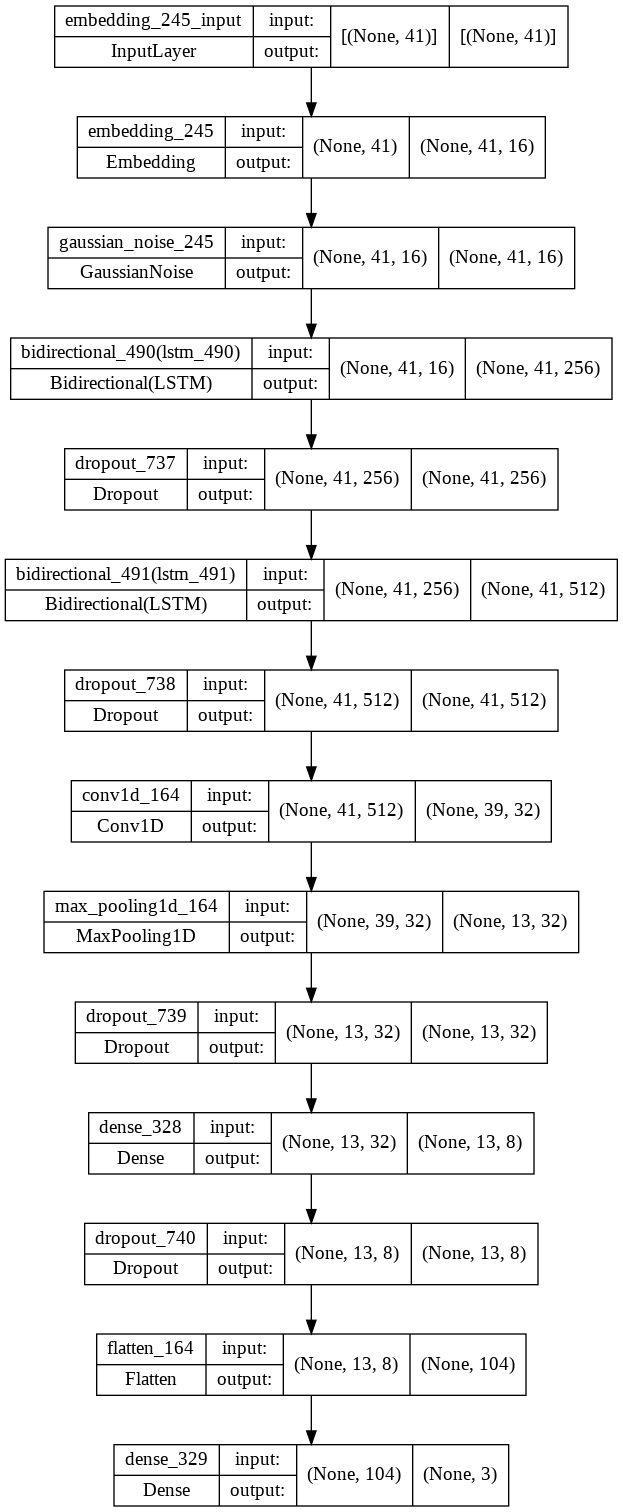

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath='ckpt_1',
  save_weights_only=True,
  monitor='val_accuracy',
  mode='max',
  save_best_only=True
)

#early stop mechanism
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10
)

history = model.fit(train_tweets,
                    train_sentiments,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    shuffle=True,
                    validation_data=(valid_tweets,valid_sentiments),
                    callbacks=[checkpoint_callback, earlystop_callback])

Epoch 1/1000
33/33 [==============================] - 38s 802ms/step - loss: 1.1018 - accuracy: 0.3385 - val_loss: 1.1004 - val_accuracy: 0.4769
Epoch 2/1000
33/33 [==============================] - 25s 751ms/step - loss: 1.0997 - accuracy: 0.3942 - val_loss: 1.0987 - val_accuracy: 0.4769
Epoch 3/1000
33/33 [==============================] - 27s 807ms/step - loss: 1.0974 - accuracy: 0.4365 - val_loss: 1.0966 - val_accuracy: 0.4769
Epoch 4/1000
33/33 [==============================] - 25s 767ms/step - loss: 1.0947 - accuracy: 0.4558 - val_loss: 1.0941 - val_accuracy: 0.4769
Epoch 5/1000
33/33 [==============================] - 25s 756ms/step - loss: 1.0917 - accuracy: 0.4538 - val_loss: 1.0909 - val_accuracy: 0.4769
Epoch 6/1000
33/33 [==============================] - 25s 754ms/step - loss: 1.0861 - accuracy: 0.4788 - val_loss: 1.0864 - val_accuracy: 0.4769
Epoch 7/1000
33/33 [==============================] - 25s 765ms/step - loss: 1.0800 - accuracy: 0.4692 - val_loss: 1.0799 - val_ac

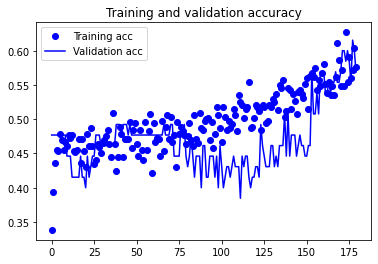

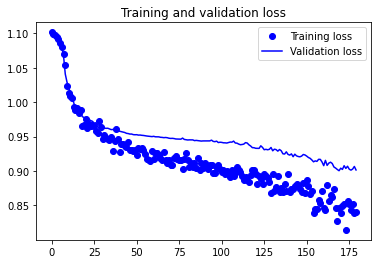

In [ ]:
plot(history)

In [ ]:
model.load_weights('ckpt_1')

In [ ]:
train_loss, train_accuracy = model.evaluate(train_tweets, train_sentiments)
train_accuracy

17/17 [==============================] - 1s 63ms/step - loss: 0.7497 - accuracy: 0.7154


0.7153846025466919

In [ ]:
valid_loss, valid_accuracy = model.evaluate(valid_tweets, valid_sentiments)
valid_accuracy

3/3 [==============================] - 0s 64ms/step - loss: 0.9028 - accuracy: 0.6154


0.6153846383094788

In [ ]:
test_loss, test_accuracy = model.evaluate(test_tweets, test_sentiments)
test_accuracy

3/3 [==============================] - 0s 60ms/step - loss: 0.9642 - accuracy: 0.4769


0.4769230782985687

In [ ]:
output_file_path = os.path.join(base_path, "Models/bi_LSTM_CNN")
model.save(output_file_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/HLT Project/Models/bi_LSTM_CNN/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/HLT Project/Models/bi_LSTM_CNN/assets


# 4.4 Transformer



##Preparing Data for Transformer

In [ ]:
from transformers import AutoTokenizer, TFAutoModel, TFAutoModelForSequenceClassification
#base or mini
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")
bert_model = TFAutoModel.from_pretrained("asafaya/bert-base-arabic")
#bert_model = TFAutoModelForSequenceClassification.from_pretrained("asafaya/bert-base-arabic", num_labels=3)

Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/491 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/326k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/520M [00:00<?, ?B/s]

Some layers from the model checkpoint at asafaya/bert-base-arabic were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at asafaya/bert-base-arabic.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
tune_tweets = tokenizer(text=tune['tweet'].tolist(),
                         is_split_into_words=True,
                         add_special_tokens=True,
                         max_length=max,
                         truncation=True,
                         padding='max_length',
                         return_tensors='tf',
                         return_token_type_ids=False,
                         return_attention_mask=True,
                         verbose=True)

train_tweets = tokenizer(text=train['tweet'].tolist(),
                         is_split_into_words=True,
                         add_special_tokens=True,
                         max_length=max,
                         truncation=True,
                         padding='max_length',
                         return_tensors='tf',
                         return_token_type_ids=False,
                         return_attention_mask=True,
                         verbose=True)

valid_tweets = tokenizer(text=valid['tweet'].tolist(),
                         is_split_into_words=True,
                         add_special_tokens=True,
                         max_length=max,
                         truncation=True,
                         padding='max_length',
                         return_tensors='tf',
                         return_token_type_ids=False,
                         return_attention_mask=True,
                         verbose=True)

test_tweets = tokenizer(text=test['tweet'].tolist(),
                         is_split_into_words=True,
                         add_special_tokens=True,
                         max_length=max,
                         truncation=True,
                         padding='max_length',
                         return_tensors='tf',
                         return_token_type_ids=False,
                         return_attention_mask=True,
                         verbose=True)

train_sentiments = [sentiment for sentiment in train['scale']]
train_sentiments = to_categorical(np.array(train_sentiments), len(sentiments))
tune_sentiments = [sentiment for sentiment in tune['scale']]
tune_sentiments = to_categorical(np.array(tune_sentiments), len(sentiments))
valid_sentiments = [sentiment for sentiment in valid['scale']]
valid_sentiments = to_categorical(np.array(valid_sentiments), len(sentiments))
test_sentiments = [sentiment for sentiment in test['scale']]
test_sentiments = to_categorical(np.array(test_sentiments), len(sentiments))

##Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

np.random.seed(42)

def define_transformer_model(activation='relu',
                             init_weights='uniform',
                             lr=5e-05,
                             l2=0.001,
                             batch_size=32,
                             dropout=0.3,
                             clipnorm=1,
                             dense=16,
                             output_transformer=0):
  input = Input(shape=(2,max), dtype=tf.int32)
 
  embeddings = bert_model(input_ids=tf.convert_to_tensor(input[:,0],dtype=tf.int32), attention_mask=tf.convert_to_tensor(input[:,1], dtype=tf.int32))[output_transformer]
  if output_transformer==0:
    embeddings=Flatten()(embeddings)
  out = Dropout(dropout)(embeddings)
  out = Dense(dense, activation=activation, kernel_initializer=init_weights)(out)
  out = Dropout(dropout)(out)
  output = Dense(len(sentiments), kernel_initializer=init_weights, activation='softmax', activity_regularizer=regularizers.l2(l2))(out)
  model = tf.keras.Model(inputs=input, outputs=output)
  model.layers[1].trainable=True

  opt = tf.keras.optimizers.Adam(
      clipnorm=clipnorm,
      learning_rate=lr,
      name='Adam')

  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  return model


  

In [ ]:
combi_input = np.stack([ tune_tweets['input_ids'], tune_tweets['attention_mask'] ], axis=1)

###Tuning Optimizer

In [ ]:
from scikeras.wrappers import KerasClassifier

model = KerasClassifier(model=define_transformer_model,
                        activation='relu',
                        init_weights='uniform',
                        lr=5e-05,
                        l2=0.001,
                        batch_size=32,
                        dropout=0.3,
                        clipnorm=1,
                        dense=16,
                        output_transformer=0,
                        epochs=20,
                        verbose=1)
init_weights=['random_uniform', 'uniform', 'orthogonal']
lr=[5e-05,5e-03,5e-01]
batch_size=[8,16,32]
clipnorm=[1,3,5]
param_grid=dict(init_weights=init_weights,
                lr=lr,
                batch_size=batch_size,
                clipnorm=clipnorm)


grid = GridSearchCV(estimator=model,param_grid=param_grid,cv=3)
grid_result=grid.fit(combi_input,tune_sentiments)

print(grid_result.best_score_)
print(grid_result.best_params_)
"""
0.5714285714285715
{'batch_size': 8, 'clipnorm': 1, 'init_weights': 'random_uniform', 'lr': 5e-05}
"""

###Tuning Regularization/Dropout

In [ ]:
from scikeras.wrappers import KerasClassifier
model = KerasClassifier(model=define_transformer_model,
                        activation='relu',
                        init_weights='random_uniform',
                        lr=5e-05,
                        l2=0.001,
                        batch_size=8,
                        dropout=0.3,
                        clipnorm=1,
                        dense=16,
                        output_transformer=0,
                        epochs=20,
                        verbose=1)
activation=['relu','sigmoid', 'tanh', 'elu']
l2=[0.1,0.01,0.001,0.0001]
dropout=[0.3,0.5,0.8]

param_grid=dict(activation=activation,
                l2=l2,
                dropout=dropout)

grid = GridSearchCV(estimator=model,param_grid=param_grid,cv=3)
grid_result=grid.fit(combi_input,tune_sentiments)

print(grid_result.best_score_)
print(grid_result.best_params_)
"""
0.5714285714285715
{'activation': 'relu', 'dropout': 0.3, 'l2': 0.01}
"""

###Tuning Hidden Neurons

In [ ]:
from scikeras.wrappers import KerasClassifier
model = KerasClassifier(model=define_transformer_model,
                        activation='relu',
                        init_weights='uniform',
                        lr=5e-05,
                        l2=0.01,
                        batch_size=32,
                        dropout=0.3,
                        clipnorm=1,
                        dense=16,
                        output_transformer=0,
                        epochs=20,
                        verbose=1)

dense=[8,16,32]
output_transformer=[0,1]

param_grid=dict(dense=dense,
                output_transformer=output_transformer)

grid = GridSearchCV(estimator=model,param_grid=param_grid,cv=3)
grid_result=grid.fit(combi_input,tune_sentiments)

print(grid_result.best_score_)
print(grid_result.best_params_)
"""
1.0
{'dense': 16, 'output_transformer': 0}
"""

##Training the model

In [ ]:
EPOCHS = 1000
ACTIVATION='relu'
INIT_WEIGHTS='random_uniform'
LR = 5e-05
L2=0.01
BATCH_SIZE = 8
DROPOUT=0.3
CLIPNORM=1
DENSE=16
OUTPUT_TRANSFORMER=0

model = define_transformer_model(activation=ACTIVATION,
                                 init_weights=INIT_WEIGHTS,
                                 lr=LR,
                                 l2=L2,
                                 batch_size=BATCH_SIZE,
                                 dropout=DROPOUT,
                                 clipnorm=CLIPNORM,
                                 dense=DENSE,
                                 output_transformer=OUTPUT_TRANSFORMER)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 41)]      0           []                               
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 41)          0           ['input_1[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 41)          0           ['input_1[0][0]']                
 icingOpLambda)                                                                                   
                                                                                              

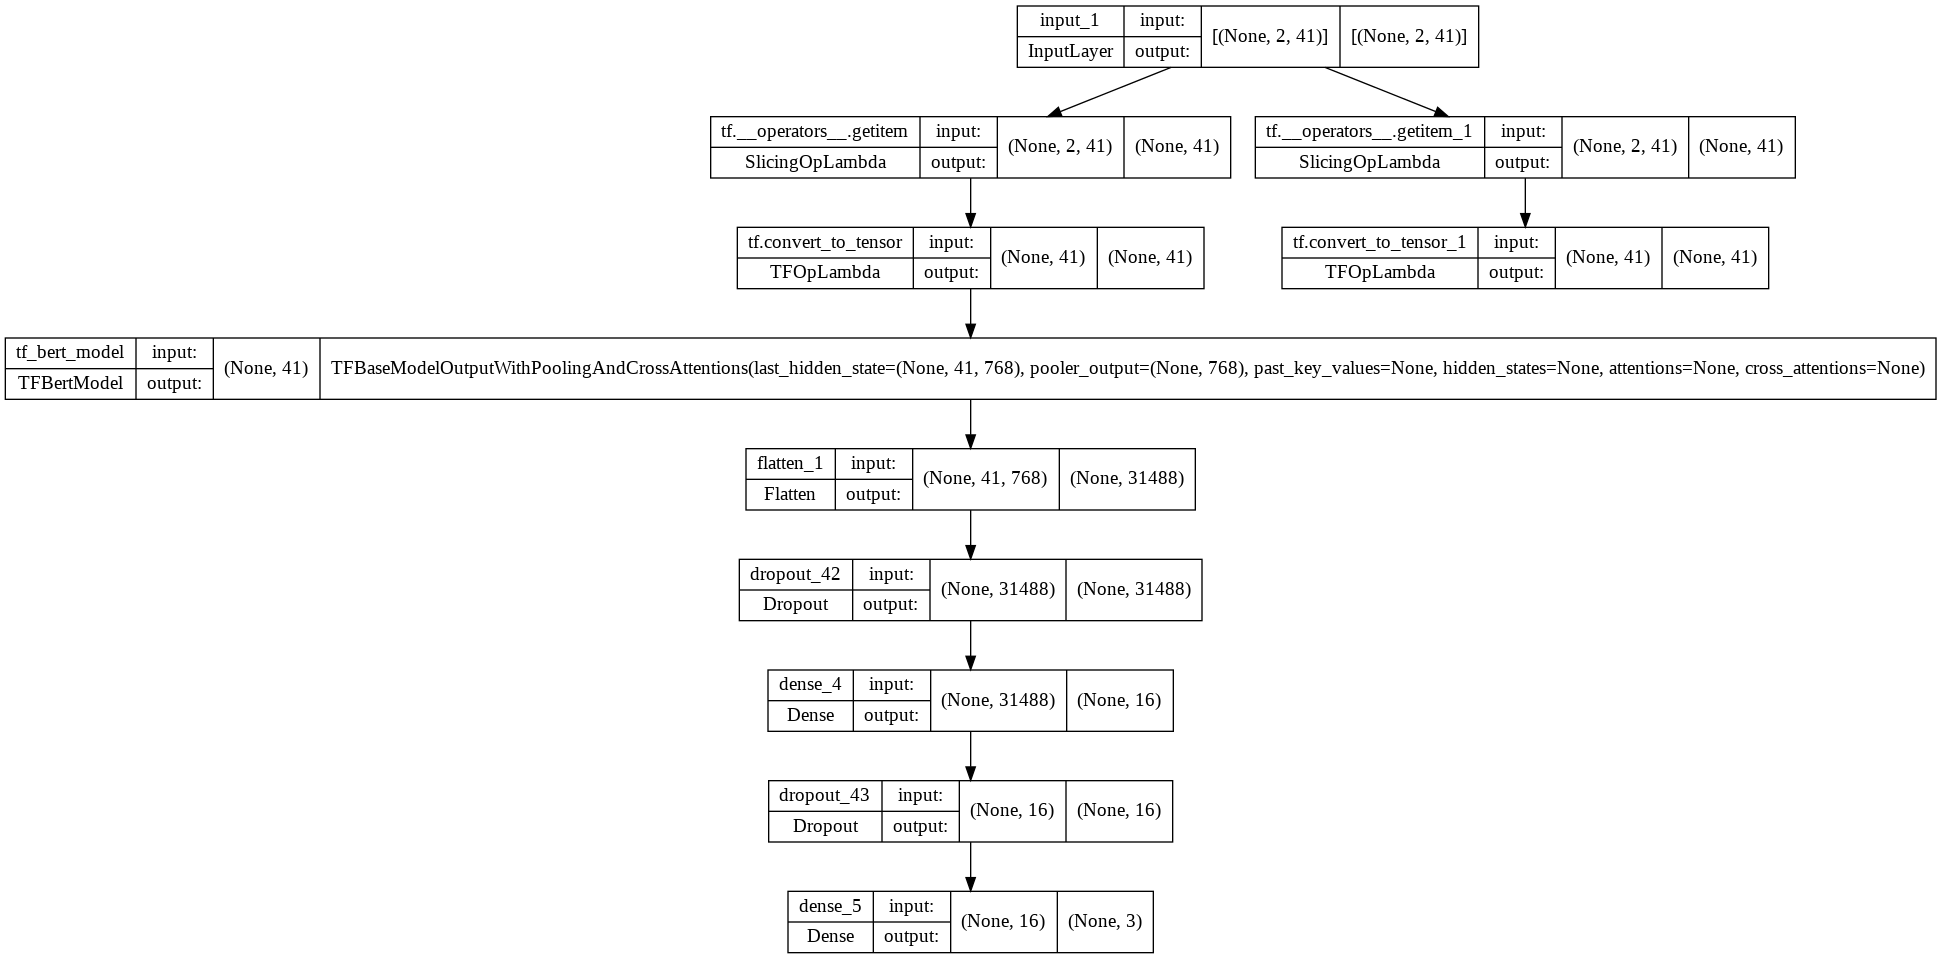

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath='ckpt_1',
  save_weights_only=True,
  monitor='val_accuracy',
  mode='max',
  save_best_only=True
)

combi_train = np.stack([ train_tweets['input_ids'], train_tweets['attention_mask'] ], axis=1)
combi_valid = np.stack([ valid_tweets['input_ids'], valid_tweets['attention_mask'] ], axis=1)

#early stop mechanism
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10
)

history = model.fit(combi_train,
                    train_sentiments,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    shuffle=True,
                    validation_data=(combi_valid,valid_sentiments),
                    callbacks=[checkpoint_callback, earlystop_callback])

Epoch 1/1000


65/65 [==============================] - 331s 5s/step - loss: 0.9366 - accuracy: 0.5173 - val_loss: 0.9685 - val_accuracy: 0.4462
Epoch 2/1000
65/65 [==============================] - 272s 4s/step - loss: 0.7807 - accuracy: 0.6154 - val_loss: 0.9743 - val_accuracy: 0.6308
Epoch 3/1000
65/65 [==============================] - 271s 4s/step - loss: 0.6499 - accuracy: 0.7058 - val_loss: 1.2126 - val_accuracy: 0.4308
Epoch 4/1000
65/65 [==============================] - 264s 4s/step - loss: 0.4376 - accuracy: 0.8269 - val_loss: 1.1181 - val_accuracy: 0.5538
Epoch 5/1000
65/65 [==============================] - 263s 4s/step - loss: 0.2341 - accuracy: 0.9269 - val_loss: 1.6135 - val_accuracy: 0.6154
Epoch 6/1000
65/65 [==============================] - 265s 4s/step - loss: 0.1307 - accuracy: 0.9596 - val_loss: 2.8035 - val_accuracy: 0.5692
Epoch 7/1000
65/65 [==============================] - 262s 4s/step - loss: 0.0793 - accuracy: 0.9865 - val_loss: 3.0122 - val_accuracy: 0.5385
Epoch 8/1000

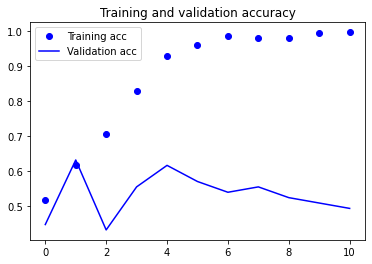

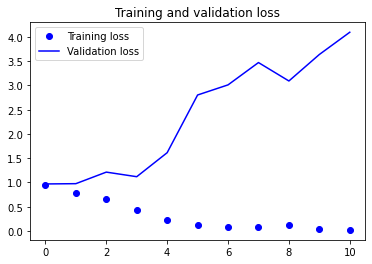

In [ ]:
plot(history)

In [ ]:
model.load_weights('ckpt_1')

In [ ]:
train_loss, train_accuracy = model.evaluate(combi_train, train_sentiments)
train_accuracy

17/17 [==============================] - 62s 4s/step - loss: 0.5635 - accuracy: 0.7558


0.7557692527770996

In [ ]:
valid_loss, valid_accuracy = model.evaluate(combi_valid, valid_sentiments)
valid_accuracy

3/3 [==============================] - 11s 2s/step - loss: 0.9743 - accuracy: 0.6308


0.6307692527770996

In [ ]:
combi_test = np.stack([ test_tweets['input_ids'], test_tweets['attention_mask'] ], axis=1)

test_loss, test_accuracy = model.evaluate(combi_test, test_sentiments)
test_accuracy

3/3 [==============================] - 8s 2s/step - loss: 0.9643 - accuracy: 0.5846


0.5846154093742371

In [ ]:
output_file_path = os.path.join(base_path, "Models/bert_overfit")
model.save(output_file_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/HLT Project/Models/bert_overfit/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/HLT Project/Models/bert_overfit/assets


#End of Main

#EVALUATION

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def eval_metrics(model, bert):
  if bert:
    combi_test = np.stack([ test_tweets['input_ids'], test_tweets['attention_mask'] ], axis=1)
    predict_probs = model.predict(combi_test) 
  else:
    predict_probs = model.predict(test_tweets)
  perdicted_classes=np.argmax(predict_probs,axis=1)
  print(perdicted_classes)
  true_classes=np.argmax(test_sentiments,axis=1)
  print(true_classes)
  precision = precision_score(true_classes, perdicted_classes, average='macro')
  recall = recall_score(true_classes, perdicted_classes, average='macro')
  f1 = f1_score(true_classes, perdicted_classes, average='macro')
  cm = confusion_matrix(true_classes, perdicted_classes)
  return np.array([[precision, recall, f1, cm]])

In [ ]:
from tabulate import tabulate

'''
MODELS PATH:
4.1 Simple: /simple
4.2 Initial Deep Learning Model: /bi_2_LSTM
4.3 LSTM + CNN: /bi_LSTM_CNN
4.4 Transformer: bert_overfit
'''
model_file_path = os.path.join(base_path, "Models/bert_overfit")
bert = True
model = None
if bert:
  ACTIVATION='relu'
  INIT_WEIGHTS='random_uniform'
  LR = 5e-05
  L2=0.01
  BATCH_SIZE = 8
  DROPOUT=0.3
  CLIPNORM=1
  DENSE=16
  OUTPUT_TRANSFORMER=0

  model = define_transformer_model(activation=ACTIVATION,
                                   init_weights=INIT_WEIGHTS,
                                   lr=LR,
                                   l2=L2,
                                   batch_size=BATCH_SIZE,
                                   dropout=DROPOUT,
                                   clipnorm=CLIPNORM,
                                   dense=DENSE,
                                   output_transformer=OUTPUT_TRANSFORMER)
  model.load_weights(model_file_path)
else:
  model = tf.keras.models.load_model(model_file_path)
print(tabulate(eval_metrics(model, bert), headers=['precision','recall','F1', 'CM']))

[0 1 1 1 1 0 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 1 1 1 0 1 0 1 0 1 1 0
 0 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1]
[0 1 1 0 1 0 1 0 1 0 0 0 2 0 1 0 1 1 0 2 0 0 0 0 0 2 0 1 1 2 0 2 1 2 1 1 1
 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 2 0 0 1 1 1 1 1 1 1 1 0]
  precision    recall        F1  CM
-----------  --------  --------  ------------
   0.397436  0.458333  0.411111  [[17 17  0]
                                  [ 3 21  0]
                                  [ 6  1  0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
print(tabulate(eval_metrics(model, bert), headers=['precision','recall','F1', 'CM']))

[2 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 2 1 1 1 1 1 1 1 1 1 1 0 1 1 1 2 1 1 1
 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1]
[0 1 1 0 1 0 1 0 1 0 0 0 2 0 1 0 1 1 0 2 0 0 0 0 0 2 0 1 1 2 0 2 1 2 1 1 1
 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 2 0 0 1 1 1 1 1 1 1 1 0]
  precision    recall        F1  CM
-----------  --------  --------  ------------
   0.193103  0.353175  0.234417  [[ 0 31  3]
                                  [ 1 22  1]
                                  [ 1  5  1]]


#Start of Extra

# 4.4.1 Transformer (fighting overfitting)



In [ ]:
input_ids = Input(shape=(max,), dtype=tf.int32, name='input_ids')
input_mask = Input(shape=(max,), dtype=tf.int32, name='attention_mask')
embeddings = bert_model(input_ids, attention_mask=input_mask)[0]
out = Flatten()(embeddings)
out = Dropout(0.8)(out)
out = Dense(64, activation='relu')(out)
out = Dropout(0.8)(out)
output = Dense(len(sentiments), activation='softmax', activity_regularizer=regularizers.l2(0.01))(out)
model = tf.keras.Model(inputs=[input_ids,input_mask], outputs=output)
model.layers[2].trainable=True

opt = tf.keras.optimizers.Adam(
    clipnorm=1,
    learning_rate=5e-08,
    name='Adam')

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 41)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 41)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  110617344   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 41,                                          

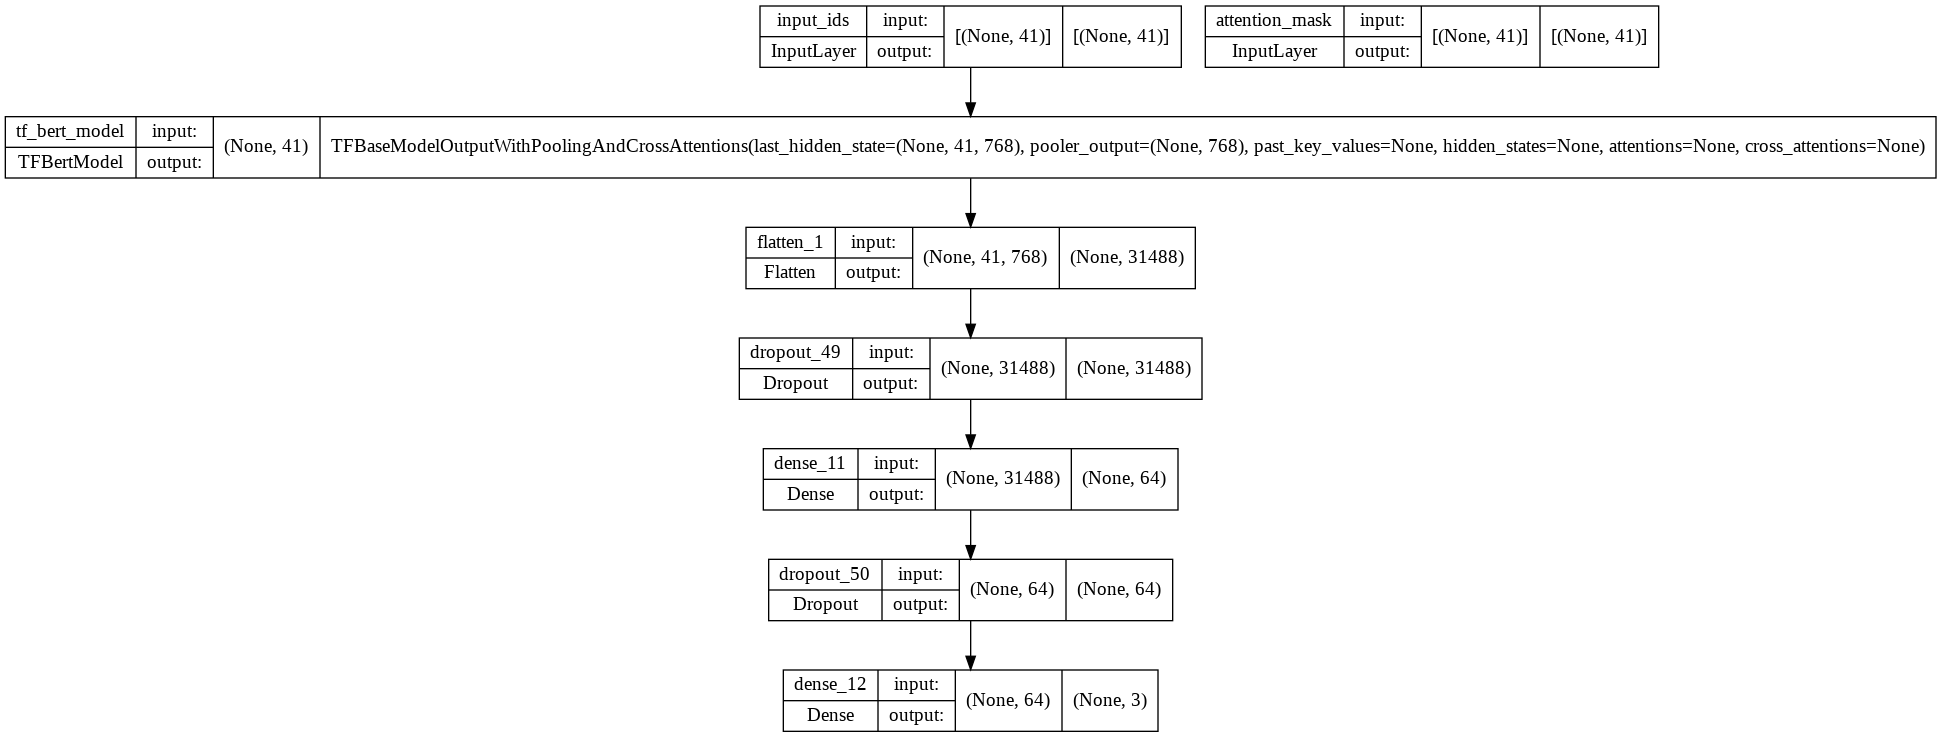

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath='ckpt_1',
  save_weights_only=True,
  monitor='val_accuracy',
  mode='max',
  save_best_only=True
)

#early stop mechanism
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20
)

history = model.fit({'input_ids': train_tweets['input_ids'], 'attention_mask':train_tweets['attention_mask']},
                    train_sentiments,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    shuffle=True,
                    validation_data=({'input_ids': valid_tweets['input_ids'], 'attention_mask':valid_tweets['attention_mask']},valid_sentiments),
                    callbacks=[checkpoint_callback, earlystop_callback])

Epoch 1/100


9/9 [==============================] - 37s 2s/step - loss: 4.8769 - accuracy: 0.3731 - val_loss: 2.0896 - val_accuracy: 0.4478
Epoch 2/100
9/9 [==============================] - 5s 528ms/step - loss: 4.5136 - accuracy: 0.4179 - val_loss: 2.0657 - val_accuracy: 0.4478
Epoch 3/100
9/9 [==============================] - 5s 535ms/step - loss: 4.7777 - accuracy: 0.3881 - val_loss: 2.0422 - val_accuracy: 0.4478
Epoch 4/100
9/9 [==============================] - 5s 537ms/step - loss: 4.3140 - accuracy: 0.3974 - val_loss: 2.0191 - val_accuracy: 0.4478
Epoch 5/100
9/9 [==============================] - 5s 541ms/step - loss: 4.8919 - accuracy: 0.3694 - val_loss: 1.9955 - val_accuracy: 0.4478
Epoch 6/100
9/9 [==============================] - 5s 548ms/step - loss: 4.2173 - accuracy: 0.4142 - val_loss: 1.9723 - val_accuracy: 0.4478
Epoch 7/100
9/9 [==============================] - 5s 549ms/step - loss: 4.8293 - accuracy: 0.3862 - val_loss: 1.9493 - val_accuracy: 0.4478
Epoch 8/100
9/9 [==========

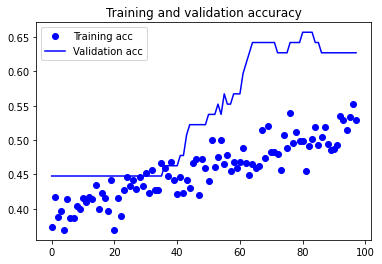

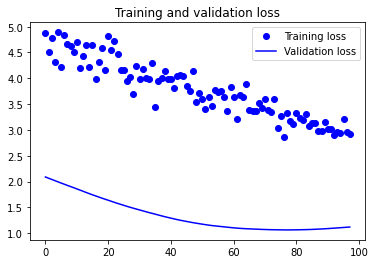

In [ ]:
plot(history)

In [ ]:
model.load_weights('ckpt_1')

In [ ]:
train_loss, train_accuracy = model.evaluate({'input_ids': train_tweets['input_ids'], 'attention_mask':train_tweets['attention_mask']}, train_sentiments)
train_accuracy

17/17 [==============================] - 2s 103ms/step - loss: 0.2865 - accuracy: 0.9104


0.9104477763175964

In [ ]:
valid_loss, valid_accuracy = model.evaluate({'input_ids': valid_tweets['input_ids'], 'attention_mask':valid_tweets['attention_mask']}, valid_sentiments)
valid_accuracy

3/3 [==============================] - 0s 81ms/step - loss: 1.0665 - accuracy: 0.6567


0.6567164063453674

In [ ]:
test_loss, test_accuracy = model.evaluate({'input_ids': test_tweets['input_ids'], 'attention_mask':test_tweets['attention_mask']}, test_sentiments)
test_accuracy

3/3 [==============================] - 0s 88ms/step - loss: 1.0457 - accuracy: 0.6029


0.6029411554336548

In [ ]:
output_file_path = os.path.join(base_path, "Models/bert_reg")
model.save(output_file_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/HLT Project/Models/bert_reg/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/HLT Project/Models/bert_reg/assets


# 4.4.2 Transformer (fighting overfitting) + CNN



In [ ]:
input_ids = Input(shape=(max,), dtype=tf.int32, name='input_ids')
input_mask = Input(shape=(max,), dtype=tf.int32, name='attention_mask')
embeddings = bert_model(input_ids, attention_mask=input_mask)[1]

convLayer = tf.keras.layers.Conv1D(50, 3, padding='same', strides=1, activation='relu')(embeddings)

convLayer = tf.keras.layers.Conv1D(50, 3, padding='same', strides=1, activation='relu')(embeddings)
poolLayer = tf.keras.layers.MaxPool1D(3)(convLayer)
out = Dropout(0.8)(poolLayer)

convLayer = tf.keras.layers.Conv1D(30, 5, strides=1, activation='relu')(out)
poolLayer = tf.keras.layers.MaxPool1D(3)(convLayer)
out = Dropout(0.8)(poolLayer)

out = Flatten()(out)
output = Dense(len(sentiments), activation='softmax', activity_regularizer=regularizers.l2(0.01))(out)
model = tf.keras.Model(inputs=[input_ids,input_mask], outputs=output)
model.layers[2].trainable=True

opt = tf.keras.optimizers.Adam(
    clipnorm=1,
    learning_rate=5e-08,
    name='Adam')

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

ValueError: ignored

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 41)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 41)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  110617344   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 41,                                            

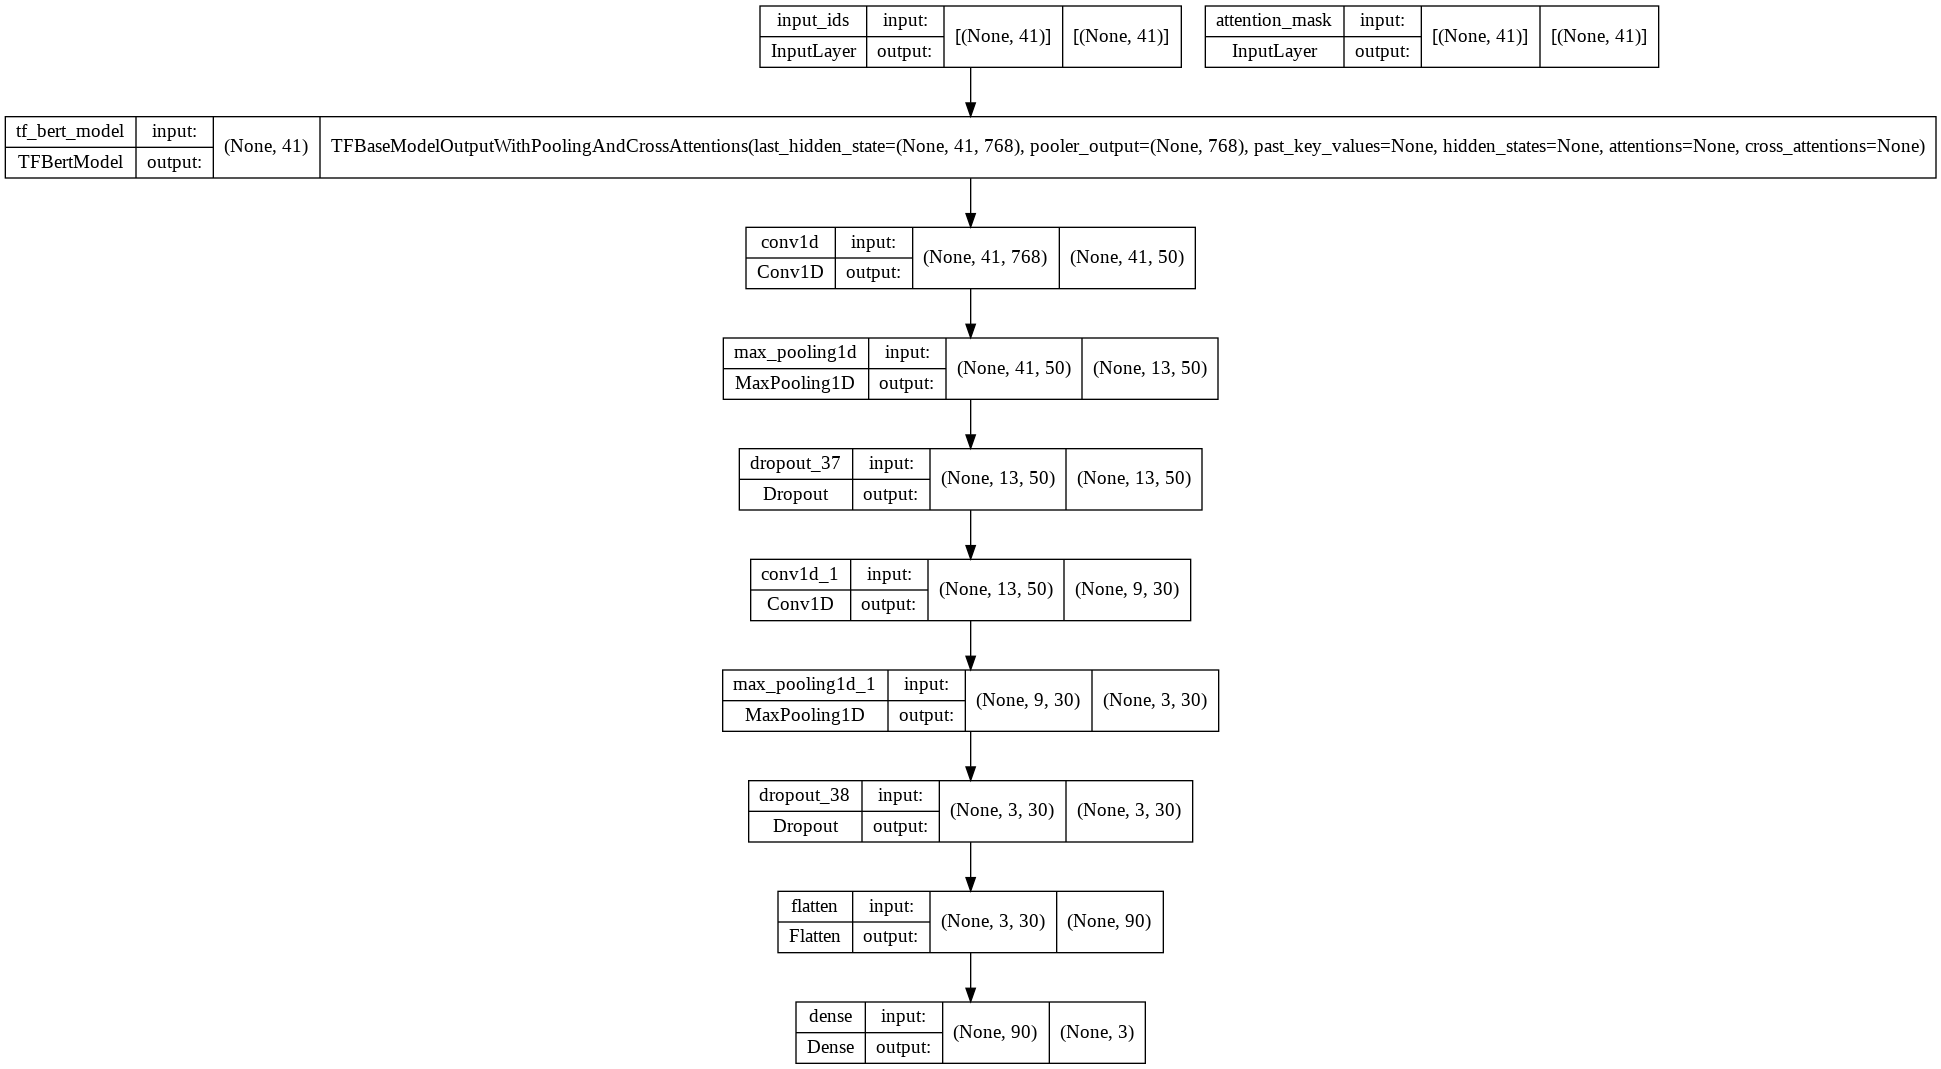

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath='ckpt_1',
  save_weights_only=True,
  monitor='val_accuracy',
  mode='max',
  save_best_only=True
)

#early stop mechanism
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20
)

history = model.fit({'input_ids': train_tweets['input_ids'], 'attention_mask':train_tweets['attention_mask']},
                    train_sentiments,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    shuffle=True,
                    validation_data=({'input_ids': valid_tweets['input_ids'], 'attention_mask':valid_tweets['attention_mask']},valid_sentiments),
                    callbacks=[checkpoint_callback, earlystop_callback])

Epoch 1/100
9/9 [==============================] - 44s 2s/step - loss: 6.7901 - accuracy: 0.3190 - val_loss: 1.6520 - val_accuracy: 0.1493
Epoch 2/100
9/9 [==============================] - 5s 512ms/step - loss: 6.2338 - accuracy: 0.2892 - val_loss: 1.6501 - val_accuracy: 0.1493
Epoch 3/100
9/9 [==============================] - 5s 516ms/step - loss: 6.5610 - accuracy: 0.2761 - val_loss: 1.6482 - val_accuracy: 0.1493
Epoch 4/100
9/9 [==============================] - 5s 517ms/step - loss: 5.9523 - accuracy: 0.3041 - val_loss: 1.6466 - val_accuracy: 0.1493
Epoch 5/100
9/9 [==============================] - 5s 525ms/step - loss: 6.2108 - accuracy: 0.2780 - val_loss: 1.6441 - val_accuracy: 0.1493
Epoch 6/100
9/9 [==============================] - 5s 528ms/step - loss: 6.2822 - accuracy: 0.2799 - val_loss: 1.6424 - val_accuracy: 0.1493
Epoch 7/100
9/9 [==============================] - 5s 530ms/step - loss: 6.4988 - accuracy: 0.2724 - val_loss: 1.6411 - val_accuracy: 0.1493
Epoch 8/100
9/9

KeyboardInterrupt: ignored

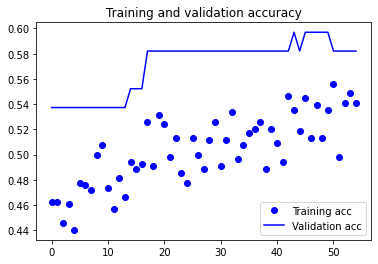

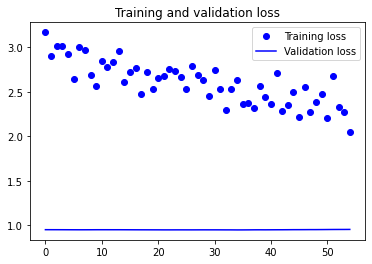

In [ ]:
plot(history)

In [ ]:
model.load_weights('ckpt_1')

In [ ]:
train_loss, train_accuracy = model.evaluate({'input_ids': train_tweets['input_ids'], 'attention_mask':train_tweets['attention_mask']}, train_sentiments)
train_accuracy

17/17 [==============================] - 2s 98ms/step - loss: 0.4894 - accuracy: 0.9198


0.9197761416435242

In [ ]:
valid_loss, valid_accuracy = model.evaluate({'input_ids': valid_tweets['input_ids'], 'attention_mask':valid_tweets['attention_mask']}, valid_sentiments)
valid_accuracy

3/3 [==============================] - 0s 65ms/step - loss: 0.9483 - accuracy: 0.5970


0.5970149040222168

In [ ]:
test_loss, test_accuracy = model.evaluate({'input_ids': test_tweets['input_ids'], 'attention_mask':test_tweets['attention_mask']}, test_sentiments)
test_accuracy

3/3 [==============================] - 0s 102ms/step - loss: 0.9876 - accuracy: 0.5735


0.5735294222831726

In [ ]:
output_file_path = os.path.join(base_path, "Models/bert_reg_cnn")
model.save(output_file_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/HLT Project/Models/bert_reg_cnn/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/HLT Project/Models/bert_reg_cnn/assets


#4.2 Paper Model (LSTM + Attention)

In [ ]:
#Transformer
import torch
modified_train = [' '.join(tw) for tw in train['tweet']]
train_wps_ids = [tokenizer.encode(s) for s in modified_train]
train_wps_tensors = [torch.tensor([wp]) for wp in train_wps_ids]
train_outputs = [bert_model(wpt, output_hidden_states=True, output_attentions=True) for  wpt in train_wps_tensors]
train_tweets = [output.last_hidden_state[0][:3].detach().numpy() for output in train_outputs]

modified_valid = [' '.join(tw) for tw in valid['tweet']]
valid_wps_ids = [tokenizer.encode(s) for s in modified_valid]
valid_wps_tensors = [torch.tensor([wp]) for wp in valid_wps_ids]
valid_outputs_model = [bert_model(wpt, output_hidden_states=True, output_attentions=True) for  wpt in valid_wps_tensors]
valid_tweets = [output.last_hidden_state[0][:3].detach().numpy() for output in valid_outputs_model]

modified_test = [' '.join(tw) for tw in test['tweet']]
test_wps_ids = [tokenizer.encode(s) for s in modified_test]
test_wps_tensors = [torch.tensor([wp]) for wp in test_wps_ids]
test_outputs_model = [bert_model(wpt, output_hidden_states=True, output_attentions=True) for  wpt in test_wps_tensors]
test_tweets = [output.last_hidden_state[0][:3].detach().numpy() for output in test_outputs_model]

train_sentiments = [sentiment for sentiment in train['scale']]
train_sentiments = to_categorical(np.array(train_sentiments), len(sentiments))
valid_sentiments = [sentiment for sentiment in valid['scale']]
valid_sentiments = to_categorical(np.array(valid_sentiments), len(sentiments))
test_sentiments = [sentiment for sentiment in test['scale']]
test_sentiments = to_categorical(np.array(test_sentiments), len(sentiments))


#train_tweets[0], train_sentiments[0], test_tweets[0], test_sentiments[0]

In [ ]:
for x in train_tweets:
  if x.shape != (3,256):
    print(x.shape)

In [ ]:
input = Input(shape=(max,))
embedding = Embedding(input_dim=len(words), output_dim=EMBEDDING_DIM, input_length=max, mask_zero=True)(input)
noise = GaussianNoise(0.3)(embedding)
x = Dropout(0.3)(noise)
seq  = Bidirectional(LSTM(RNN_HIDDEN_SIZE, return_sequences=True, dropout=0.3))(x)
x = Dropout(0.3)(seq)
seq = Bidirectional(LSTM(RNN_HIDDEN_SIZE, return_sequences=True, dropout=0.3))(x)
attention = Dense(1, activation='tanh')(seq)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(RNN_HIDDEN_SIZE*2)(attention)
attention = Permute([2,1])(attention)
sent_rep = Multiply()([seq, attention])
sent_rep = Lambda(lambda xin: K.sum(xin, axis=2), output_shape=(RNN_HIDDEN_SIZE*2,))(sent_rep)
sent_rep = Dense(16, activation='relu')(sent_rep)
sent_rep = Dropout(0.5)(sent_rep)
output = Dense(len(sentiments), activation='softmax', activity_regularizer=regularizers.l2(0.00001))(sent_rep)
model = tf.keras.Model(inputs=input, outputs=output)
"""
model = Sequential()
model.add(Embedding(len(word2index)+1, EMBEDDING_DIM, input_length=max, mask_zero=True))
model.add(GaussianNoise(0.3))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(300, return_sequences=False, dropout=0.3)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(len(sentiments), activation='softmax', activity_regularizer=regularizers.l2(0.0001)))  
"""
opt = tf.keras.optimizers.Adam(
    clipnorm=1,
    learning_rate=0.001,
    name='Adam')

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

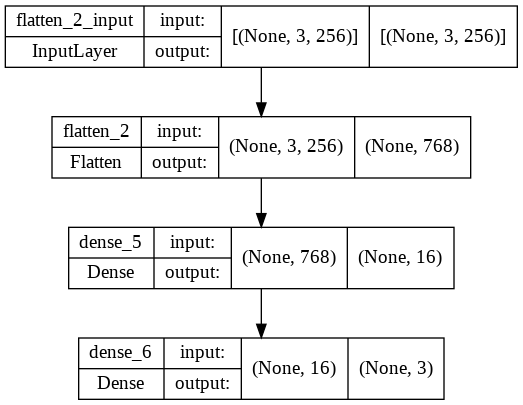

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(np.array(train_tweets),
                    to_categorical(np.array(train_sentiments), len(sentiments)),
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.2)

Epoch 1/100
7/7 [==============================] - 9s 187ms/step - loss: 1.0086 - accuracy: 0.4346 - val_loss: 0.9783 - val_accuracy: 0.4259
Epoch 2/100
7/7 [==============================] - 0s 21ms/step - loss: 0.9629 - accuracy: 0.4836 - val_loss: 0.9356 - val_accuracy: 0.5278
Epoch 3/100
7/7 [==============================] - 0s 22ms/step - loss: 0.9377 - accuracy: 0.4953 - val_loss: 0.9540 - val_accuracy: 0.4815
Epoch 4/100
7/7 [==============================] - 0s 23ms/step - loss: 0.9228 - accuracy: 0.5187 - val_loss: 0.9321 - val_accuracy: 0.5370
Epoch 5/100
7/7 [==============================] - 0s 24ms/step - loss: 0.8915 - accuracy: 0.5724 - val_loss: 0.9156 - val_accuracy: 0.5556
Epoch 6/100
7/7 [==============================] - 0s 21ms/step - loss: 0.8314 - accuracy: 0.6098 - val_loss: 0.9298 - val_accuracy: 0.5370
Epoch 7/100
7/7 [==============================] - 0s 22ms/step - loss: 0.8232 - accuracy: 0.5935 - val_loss: 0.8763 - val_accuracy: 0.5926
Epoch 8/100
7/7 [==

In [ ]:
test_loss, test_accuracy = model.evaluate(test_tweets, to_categorical(test_sentiments, len(sentiments)))
test_accuracy

5/5 [==============================] - 0s 33ms/step - loss: 1.3877 - accuracy: 0.6148


0.614814817905426

In [ ]:
#Transformer
import torch
modified_train = [' '.join(tw) for tw in train['tweet']]
train_wps_ids = [tokenizer.encode(s) for s in modified_train]
train_wps_tensors = [torch.tensor([wp]) for wp in train_wps_ids]
train_outputs = [bert_model(wpt, output_hidden_states=True, output_attentions=True) for  wpt in train_wps_tensors]
train_tweets = [output.last_hidden_state[0][:3].detach().numpy() for output in train_outputs]

modified_valid = [' '.join(tw) for tw in valid['tweet']]
valid_wps_ids = [tokenizer.encode(s) for s in modified_valid]
valid_wps_tensors = [torch.tensor([wp]) for wp in valid_wps_ids]
valid_outputs_model = [bert_model(wpt, output_hidden_states=True, output_attentions=True) for  wpt in valid_wps_tensors]
valid_tweets = [output.last_hidden_state[0][:3].detach().numpy() for output in valid_outputs_model]

modified_test = [' '.join(tw) for tw in test['tweet']]
test_wps_ids = [tokenizer.encode(s) for s in modified_test]
test_wps_tensors = [torch.tensor([wp]) for wp in test_wps_ids]
test_outputs_model = [bert_model(wpt, output_hidden_states=True, output_attentions=True) for  wpt in test_wps_tensors]
test_tweets = [output.last_hidden_state[0][:3].detach().numpy() for output in test_outputs_model]

train_sentiments = [sentiment for sentiment in train['scale']]
train_sentiments = to_categorical(np.array(train_sentiments), len(sentiments))
valid_sentiments = [sentiment for sentiment in valid['scale']]
valid_sentiments = to_categorical(np.array(valid_sentiments), len(sentiments))
test_sentiments = [sentiment for sentiment in test['scale']]
test_sentiments = to_categorical(np.array(test_sentiments), len(sentiments))


#train_tweets[0], train_sentiments[0], test_tweets[0], test_sentiments[0]

In [ ]:
for x in train_tweets:
  if x.shape != (3,256):
    print(x.shape)